In [1]:
from utils.config import CONFIG
CONFIG.PSP_USE_MEAN = True
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
from psp.pSp_pure import pSp
from utils.dataset import MulticlassImageDataset
from pathlib import Path
import matplotlib.pyplot as plt
output_dir = Path("output/paper/latent_space_exploration")
output_dir.mkdir(parents=True, exist_ok=True)

In [2]:
covid_ckpt = torch.load("output/psp_pure_pneumonia_chosen_softer/checkpoint/160000.pt", map_location="cuda:1")
covid_net = pSp(covid_ckpt).to("cuda:1")
covid_net.latent_avg = covid_net.latent_avg.to("cuda:1") if covid_net.latent_avg is not None else None
covid_net.eval()
covid_dataset = MulticlassImageDataset(
    ["input/data/covid_ct_pneumonia/train"],
    ["lung", "localizer", "bones", "drr", "soft"],
)
covid_dataloader = DataLoader(
    covid_dataset,
    batch_size=8,
    shuffle=False,
)
del covid_ckpt

Loading images from each class: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


In [3]:
lidc_ckpt = torch.load("output/psp_pure_lidc_chosen_softer/checkpoint/160000.pt", map_location="cuda:2")
lidc_net = pSp(lidc_ckpt).to("cuda:2")
lidc_net.latent_avg = lidc_net.latent_avg.to("cuda:2") if lidc_net.latent_avg is not None else None
lidc_net.eval()
lidc_dataset = MulticlassImageDataset(
    ["input/data/lidc/train"],
    ["lung", "localizer", "bones", "drr", "soft"],
)
lidc_dataloader = DataLoader(
    lidc_dataset,
    batch_size=8,
    shuffle=False,
)
del lidc_ckpt

Loading images from each class: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


In [4]:
def to_device(tensor_dict, device: str = "cuda"):
    output = {k: v.to(device) for k, v in tensor_dict.items()}
    return output


def get_w_plus(net, item, device):
    return net(to_device(item, device)["lung"])[1]

def get_mean_w_plus(net, dataloader, device):
    with torch.no_grad():
        w_plus_list = [get_w_plus(net, item, device) for item in tqdm(dataloader)]
    return torch.concat(w_plus_list, dim=0).mean(dim=0)

def plot(img):
    fig, ax = plt.subplots(1, 1, figsize=(25,25))
    ax.imshow(img[0].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")


In [5]:
covid_mean = get_mean_w_plus(covid_net, covid_dataloader, "cuda:1")
lidc_mean = get_mean_w_plus(lidc_net, lidc_dataloader, "cuda:2")

100%|██████████| 85/85 [00:12<00:00,  7.02it/s]


In [6]:
delta_latent = covid_mean.to("cuda:0") - lidc_mean.to("cuda:0")

In [9]:
dataloader = DataLoader(
    covid_dataset,
    batch_size=1,
    shuffle=False,
)
for idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    with torch.no_grad():
        sample_img = batch["lung"].to("cuda:1")
        sample_img_out, sample_w_plus = covid_net(sample_img)
        sample_img_add = covid_net.decoder([sample_w_plus + delta_latent.to("cuda:1")], return_latents=False, input_type="w_plus", noises=None)
        sample_img_add_two =  covid_net.decoder([sample_w_plus + 2*delta_latent.to("cuda:1")], return_latents=False, input_type="w_plus", noises=None)
        sample_img_minus = covid_net.decoder([sample_w_plus - delta_latent.to("cuda:1")], return_latents=False, input_type="w_plus", noises=None)
        sample_img_minus_two = covid_net.decoder([sample_w_plus - 2*delta_latent.to("cuda:1")], return_latents=False, input_type="w_plus", noises=None)
    img = torch.concat([sample_img,sample_img_minus_two,sample_img_minus,sample_img_out, sample_img_add, sample_img_add_two], dim=3)
    save_image(
        img,
        str(output_dir / f"{str(idx).zfill(6)}.png"),
        nrow=1,
        normalize=True,
        value_range=(-1, 1),
    )

100%|██████████| 642/642 [01:50<00:00,  5.78it/s]


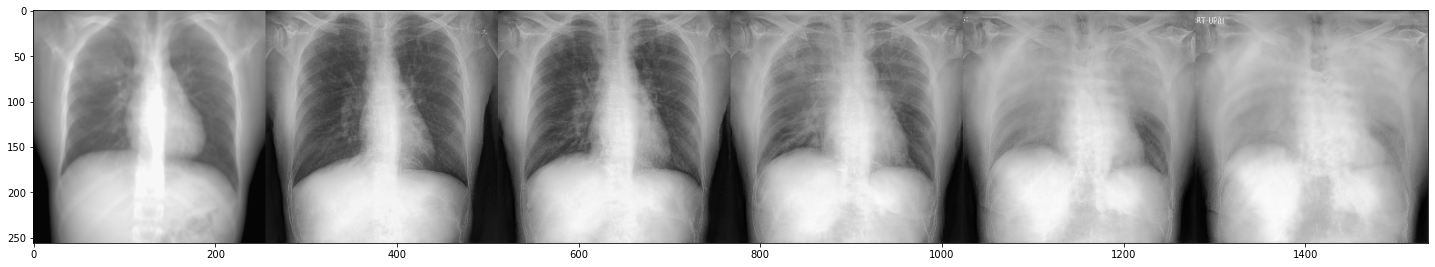

In [35]:
with torch.no_grad():
    sample_img = covid_dataset[15]["lung"].to("cuda:1").unsqueeze(0)
    sample_img_out, sample_w_plus = covid_net(sample_img)
    sample_img_add = covid_net.decoder([sample_w_plus + delta_latent.to("cuda:1")], return_latents=False, input_type="w_plus", noises=None)
    sample_img_add_two = covid_net.decoder([sample_w_plus + 2*delta_latent.to("cuda:1")], return_latents=False, input_type="w_plus", noises=None)
    sample_img_minus = covid_net.decoder([sample_w_plus - delta_latent.to("cuda:1")], return_latents=False, input_type="w_plus", noises=None)
    sample_img_minus_two = covid_net.decoder([sample_w_plus - 2*delta_latent.to("cuda:1")], return_latents=False, input_type="w_plus", noises=None)
plot(torch.concat([sample_img,sample_img_minus_two,sample_img_minus,sample_img_out, sample_img_add, sample_img_add_two], dim=2))